## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir + '/src')

In [2]:
from policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib

# from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from dataset.demos import Demos, PartialFrameViewDemos
import policy.models.tpgmm
from utils.misc import load_scene_data, DataNamingConfig
from utils.logging import setup_logger  # noqa: F401
from utils.franka import reconstruct_actions
from viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2024-06-20 11:43:19.151 | INFO     |  Running on cuda:0


In [3]:
task = 'Drawer'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)


2024-06-20 11:43:20.762 | INFO     |  Loading dataset(s): 
2024-06-20 11:43:20.762 | INFO     |    Initializing datasete using /home/hartzj/MT-GMM/data/Drawer/demos/metadata.json
2024-06-20 11:43:20.765 | INFO     |    Extracted gt object labels []
2024-06-20 11:43:20.765 | INFO     |    Extracted tsdf object labels []
2024-06-20 11:43:20.765 | INFO     |    Done! Data contains 5 trajectories.


In [4]:
kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'exp',
}


In [5]:
observations = scene_data.get_demos(**kp_config)

reconstruct_actions(observations)

n_obs = len(observations)


In [6]:
demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=True,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True,
    kp_indeces=list(range(4)),
)

demos = Demos(observations, **data_kwargs)

2024-06-20 11:43:25.005 | INFO     |  Subsampling to length 863 using strategy mean-length.


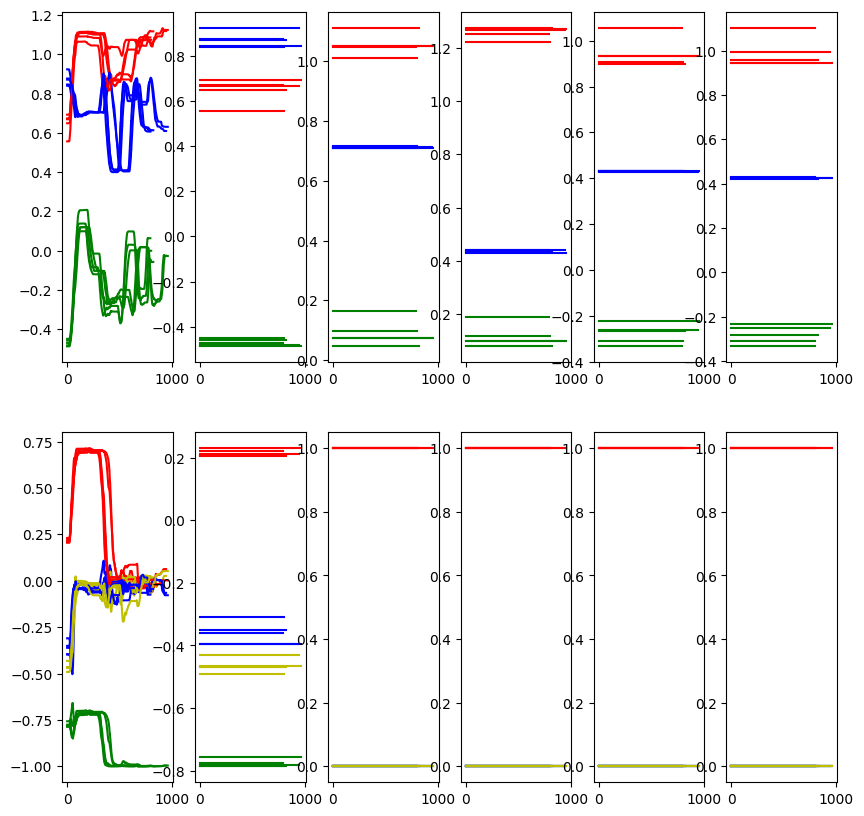

In [7]:
demos.debug_trajs()

In [8]:
tpgmm_config = TPGMMConfig(
    n_components=50,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,

    action_as_orientation=False,
    action_with_magnitude=False,

    add_gripper_action=True,

    reg_init_diag=5e-5,
    reg_diag_gripper=2e-5,
    reg_em_finish_diag_gripper=2e-5,

    reg_shrink=1e-3,
    reg_diag=5e-5,

    reg_em_finish_shrink=1e-3,
    reg_em_finish_diag=5e-5,

    fix_first_component=False,
    fix_last_component=False,

    trans_cov_mask_t_pos_corr=False,

    em_steps=1,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.0,
)

demo_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,

    repeat_final_step=0,

    components_prop_to_len=True,

    use_gripper_states=False,

    min_end_distance=35,
    min_len=5,

    velocity_threshold=0.0006,
    max_idx_distance=1,

    no_segmentation=True,
)

cascade_config = CascadeConfig(
    min_prob=0.05,
    kl_keep_rotation_dim=False
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demo_segmentation_config,
    cascade=cascade_config,
)


In [9]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-06-20 11:43:26.416 | INFO     |  Fitting AutoTPGMM
2024-06-20 11:43:26.416 | INFO     |  Performing fitting actions: [INIT]
2024-06-20 11:43:26.416 | INFO     |  Segmenting trajectories
2024-06-20 11:43:26.416 | INFO     |  ... created 1 segments
2024-06-20 11:43:26.416 | INFO     |    Fitting candidate frame 1/5
2024-06-20 11:43:26.416 | INFO     |    Creating partial frame view of demos.
2024-06-20 11:43:26.420 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2024-06-20 11:43:26.420 | INFO     |    Changing number of components to 50
2024-06-20 11:43:26.420 | INFO     |    Model init ...


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:43:33.352 | INFO     |    Fitting candidate frame 2/5
2024-06-20 11:43:33.353 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:43:40.240 | INFO     |    Fitting candidate frame 3/5
2024-06-20 11:43:40.240 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:43:47.098 | INFO     |    Fitting candidate frame 4/5
2024-06-20 11:43:47.098 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:43:53.859 | INFO     |    Fitting candidate frame 5/5
2024-06-20 11:43:53.860 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:44:00.562 | INFO     |  ee_init    score (rel):     -1 (1.000)
2024-06-20 11:44:00.562 | INFO     |  kp 0       score (rel):     -0 (0.467)
2024-06-20 11:44:00.562 | INFO     |  kp 1       score (rel):     -1 (0.802)
2024-06-20 11:44:00.562 | INFO     |  kp 2       score (rel):     -1 (0.599)
2024-06-20 11:44:00.562 | INFO     |  kp 3       score (rel):     -1 (0.578)
2024-06-20 11:44:00.563 | INFO     |  Creating partial frame view of demos.
2024-06-20 11:44:00.565 | INFO     |  Segmented trajs into 1 segments
2024-06-20 11:44:00.576 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1    kp 2      kp 3
Segment 0 -0.999936 -0.467107 -0.801841 -0.5988 -0.578364
2024-06-20 11:44:00.577 | INFO     |  Frame score (rel):
           ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0      1.0  0.467136  0.801892  0.598838  0.578401


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

2024-06-20 11:44:00.635 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[2.55e+49, 2.89e+49, 3.23e+49, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.21e+43, 1.21e+44, 1.74e+44, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.67e+16, 3.24e+16, 6.13e+16, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.10e+40, 9.02e+39, 3.75e+39],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.86e+45, 2.95e+45, 1.75e+45],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.50e+49, 2.21e+49, 1.92e+49]]),),
 (-110.03018756328655,))

In [11]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2024-06-20 11:44:27.264 | INFO     |  Fitting AutoTPGMM
2024-06-20 11:44:27.265 | INFO     |  Segmenting trajectories
2024-06-20 11:44:27.265 | INFO     |  ... created 1 segments
2024-06-20 11:44:27.265 | INFO     |    Fitting candidate frame 1/5
2024-06-20 11:44:27.265 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:44:33.894 | INFO     |    Fitting candidate frame 2/5
2024-06-20 11:44:33.894 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:44:40.666 | INFO     |    Fitting candidate frame 3/5
2024-06-20 11:44:40.667 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:44:47.391 | INFO     |    Fitting candidate frame 4/5
2024-06-20 11:44:47.391 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:44:54.073 | INFO     |    Fitting candidate frame 5/5
2024-06-20 11:44:54.073 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

2024-06-20 11:45:00.917 | INFO     |  Creating partial frame view of demos.
2024-06-20 11:45:00.990 | INFO     |  Segmented trajs into 1 segments
2024-06-20 11:45:00.992 | INFO     |  Frame score (abs):
            ee_init      kp 0      kp 1    kp 2      kp 3
Segment 0 -0.999936 -0.467107 -0.801841 -0.5988 -0.578364
2024-06-20 11:45:00.993 | INFO     |  Frame score (rel):
           ee_init      kp 0      kp 1      kp 2      kp 3
Segment 0      1.0  0.467136  0.801892  0.598838  0.578401


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[2.55e+49, 2.89e+49, 3.23e+49, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [8.21e+43, 1.21e+44, 1.74e+44, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [1.67e+16, 3.24e+16, 6.13e+16, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.10e+40, 9.02e+39, 3.75e+39],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 4.86e+45, 2.95e+45, 1.75e+45],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 2.50e+49, 2.21e+49, 1.92e+49]]),),
 (-110.03018756328655,))

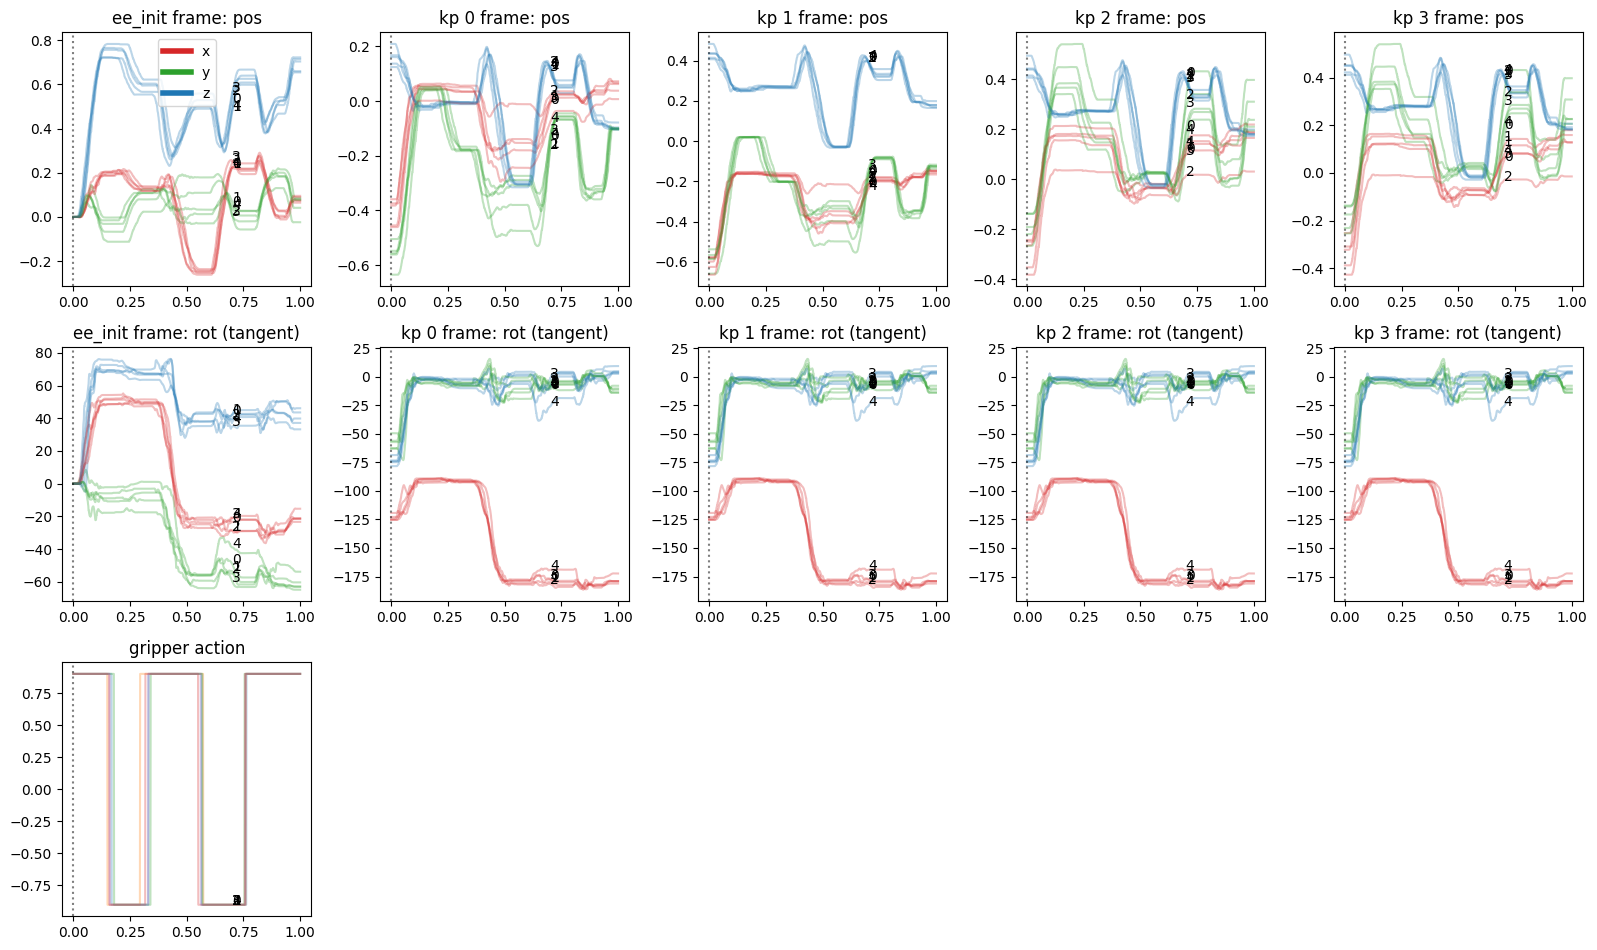

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, time_based=True,)


In [13]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       global_frames=False,
                       fitting_actions=(FittingStage.EM_HMM,))


2024-06-20 11:45:29.121 | INFO     |  Fitting AutoTPGMM
2024-06-20 11:45:29.121 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

2024-06-20 11:45:29.125 | INFO     |  HMM EM ...
2024-06-20 11:45:29.171 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/1 [00:00<?, ?it/s]

2024-06-20 11:45:35.486 | INFO     |  HMM init priors not defined, initializing to uniform
2024-06-20 11:47:56.387 | WARNING  |  HMM EM did not converge


((array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [3.22e-06, 4.18e-06, 5.39e-06, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [6.53e-34, 1.12e-33, 1.90e-33, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         ...,
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 8.39e-10, 4.08e-10, 1.95e-10],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.95e-04, 1.34e-04, 9.10e-05],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),),
 (94956.05186711636,))

2024-06-20 11:47:56.481 | INFO     |  Did not specify time_based, deciding automatically.


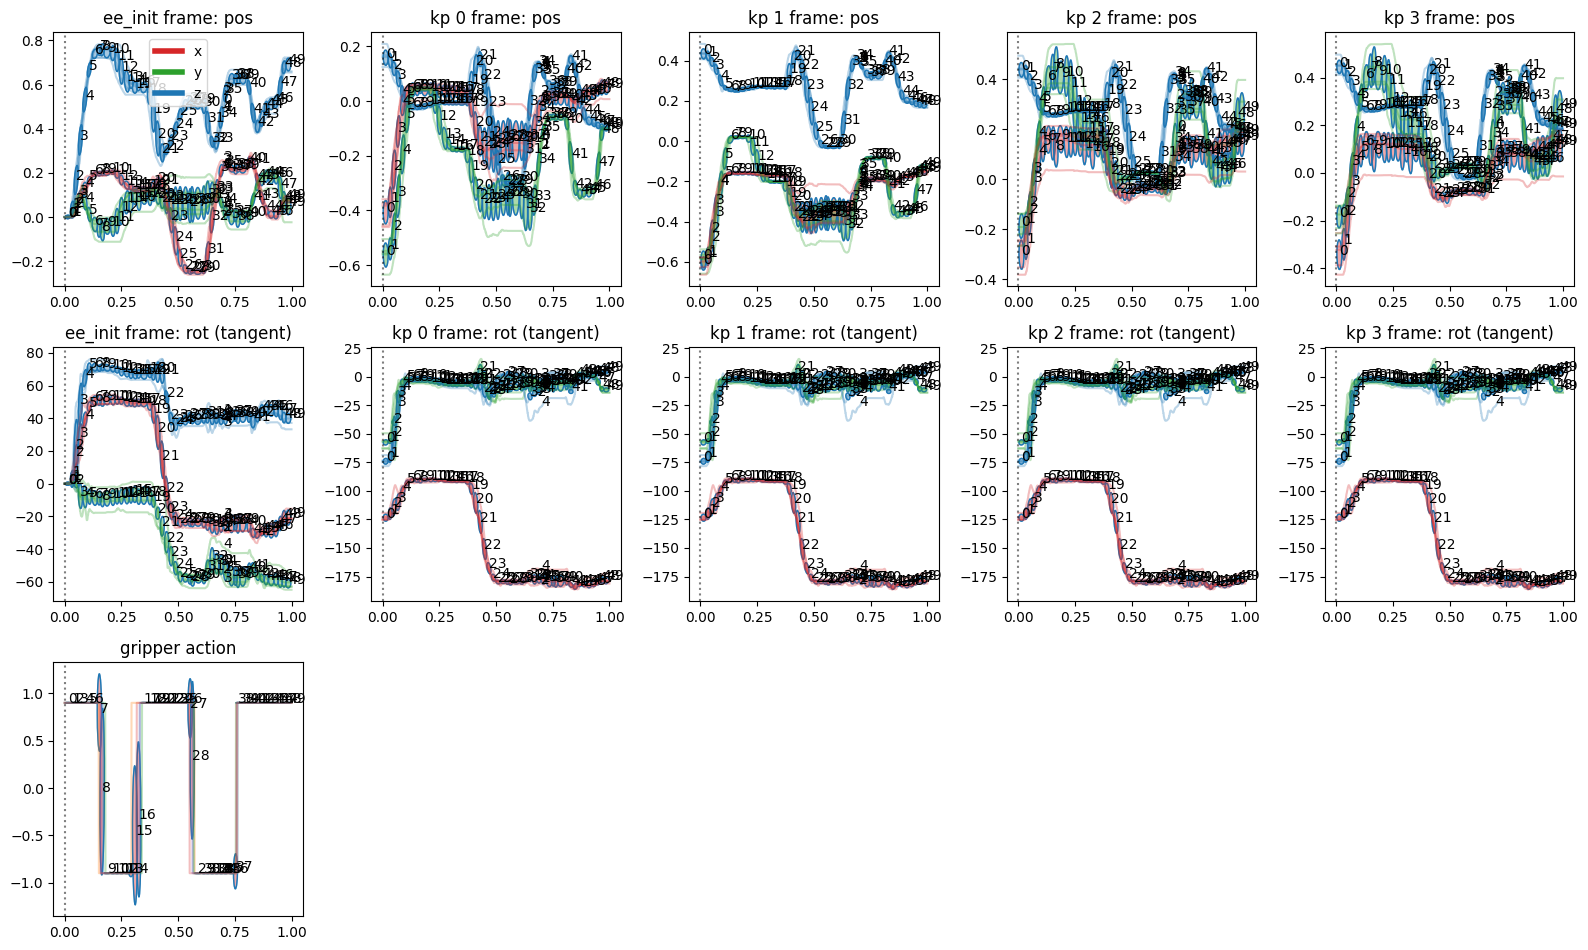

In [14]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


In [15]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-tx-tpgmm.pt')

2024-06-20 11:48:06.115 | INFO     |  Saving model:


2024-06-20 11:48:06.187 | INFO     |  Did not specify time_based, deciding automatically.


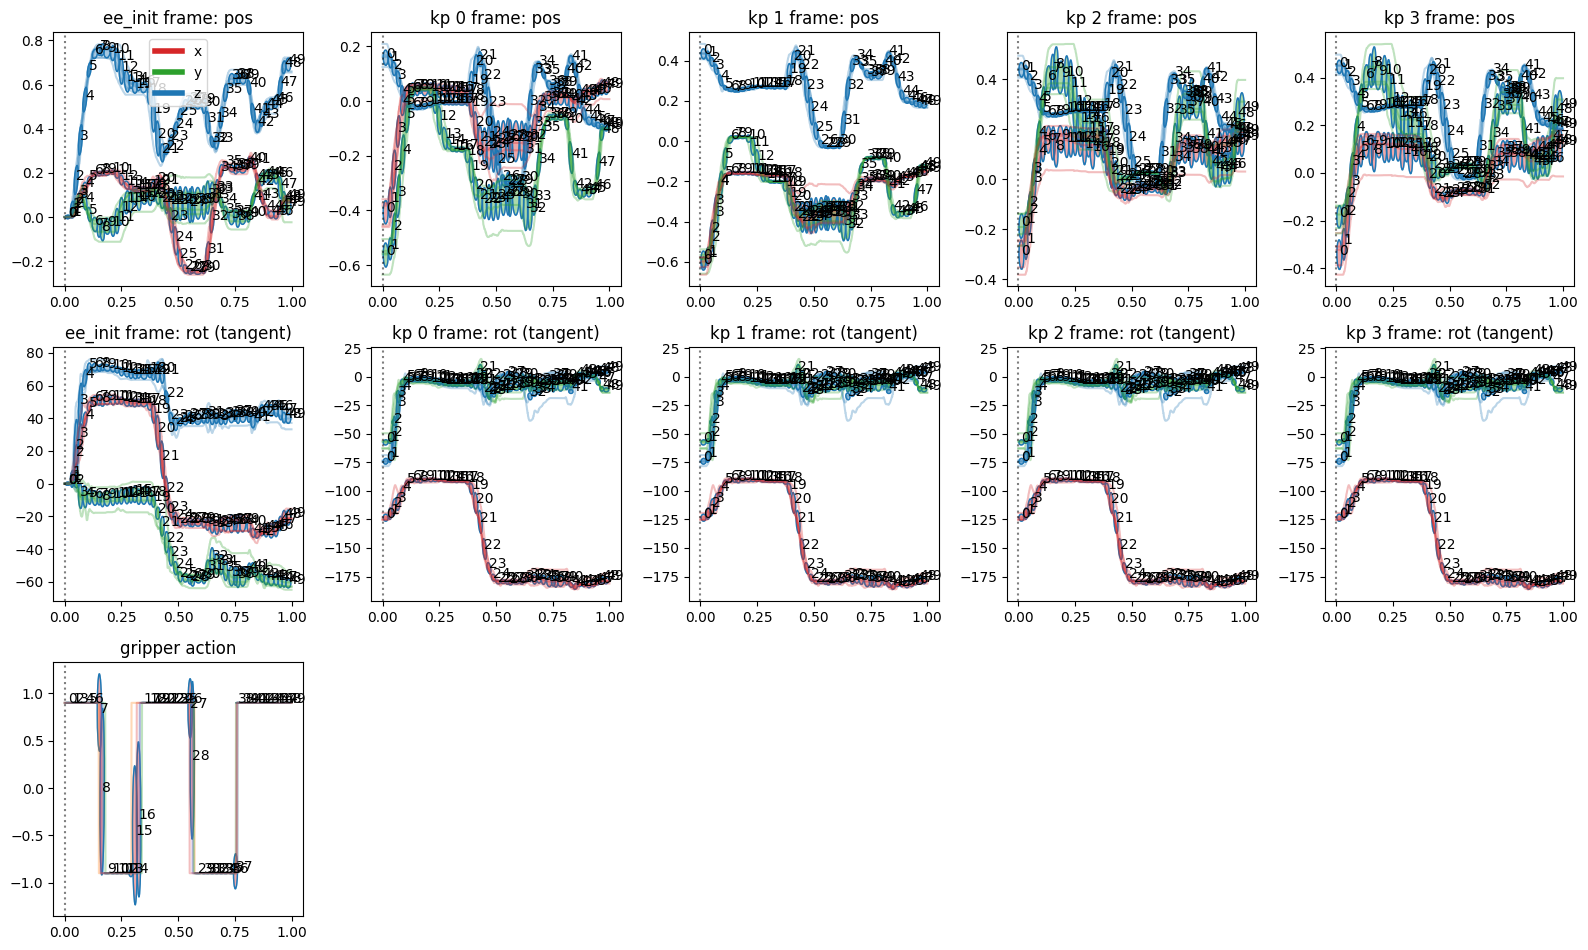

In [16]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False)


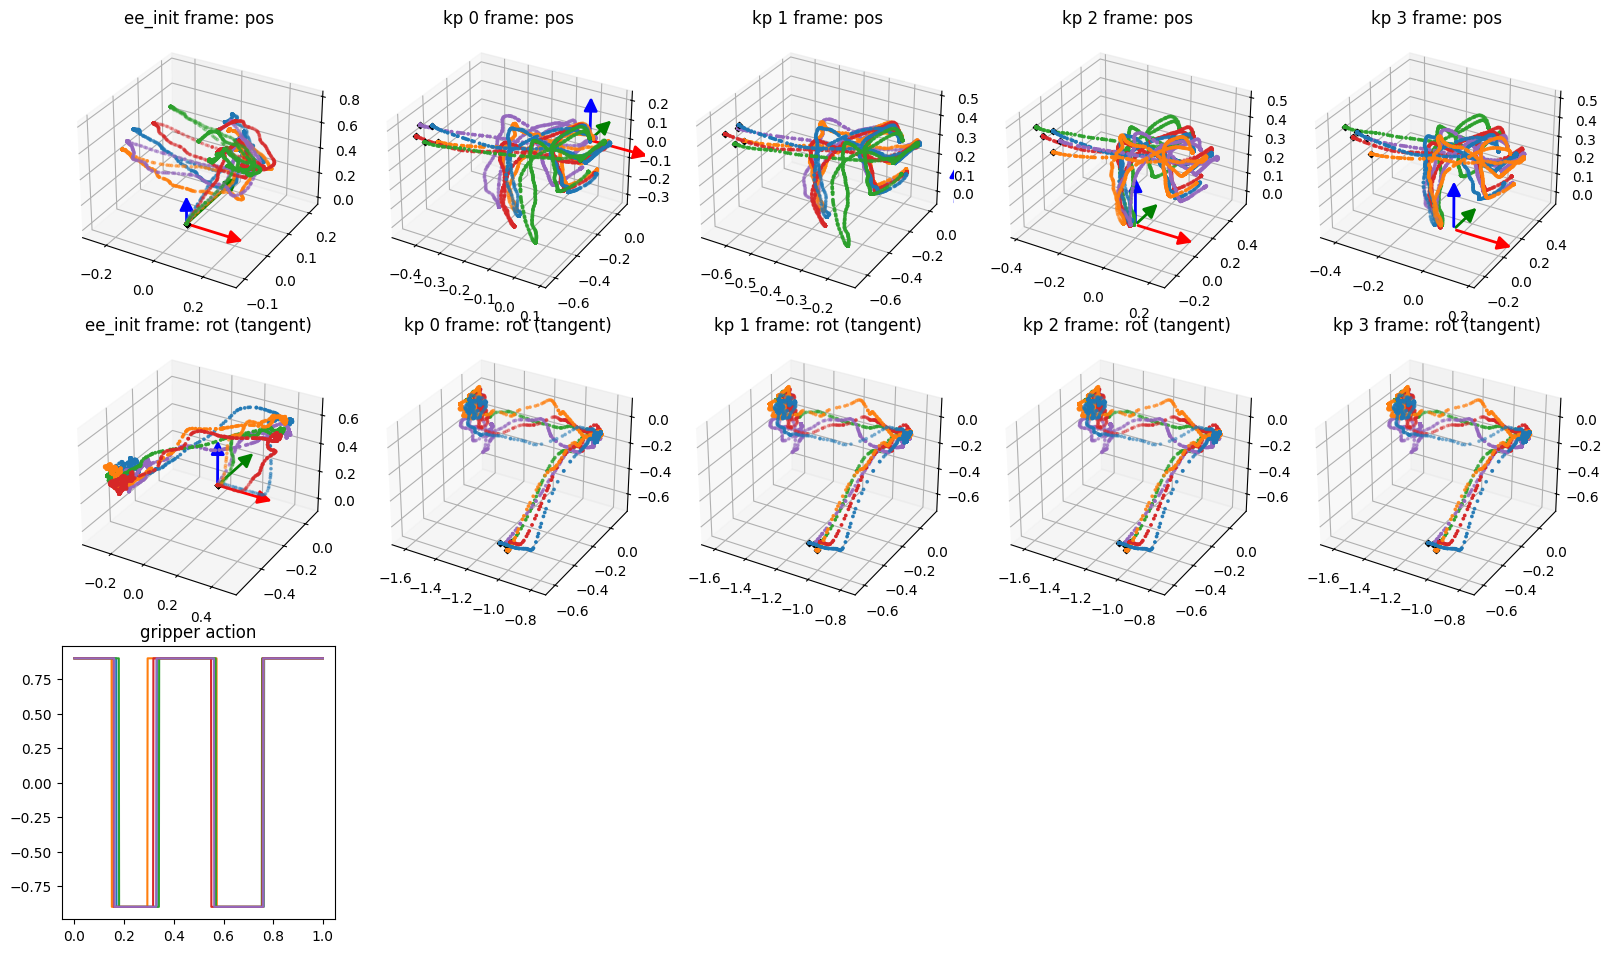

In [17]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

In [18]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2024-06-20 11:48:17.912 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2024-06-20 11:48:17.913 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

GMR:   0%|          | 0/5 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 6, got 4)

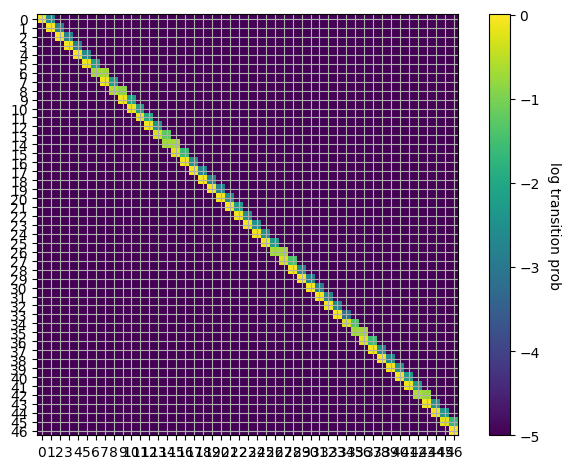

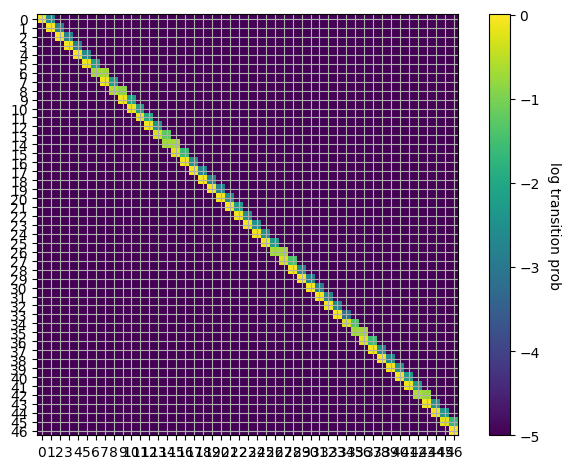

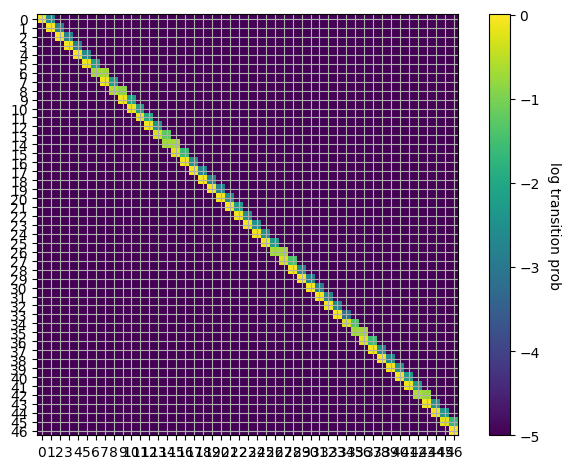

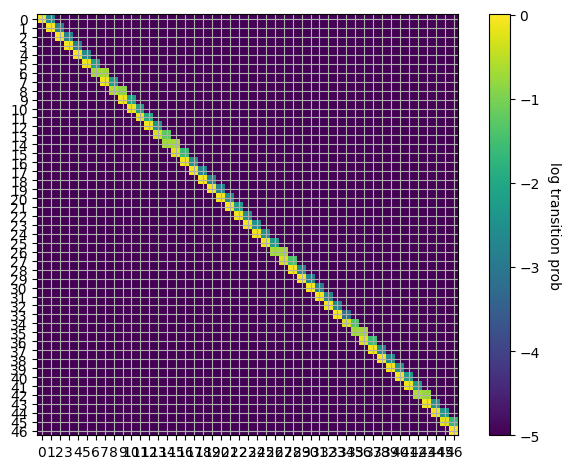

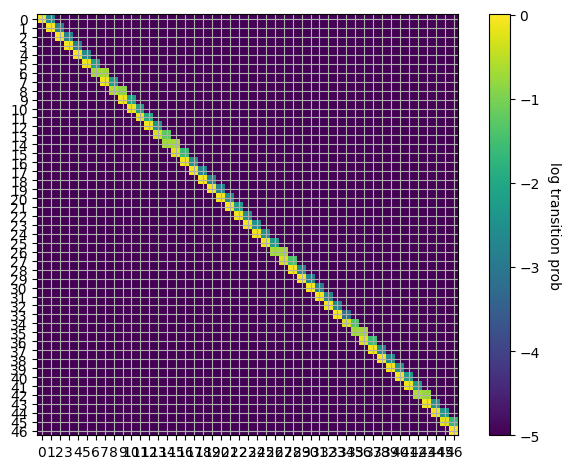

In [ ]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)


2024-06-18 16:59:15.929 | INFO     |  Taking frame origins from demos.


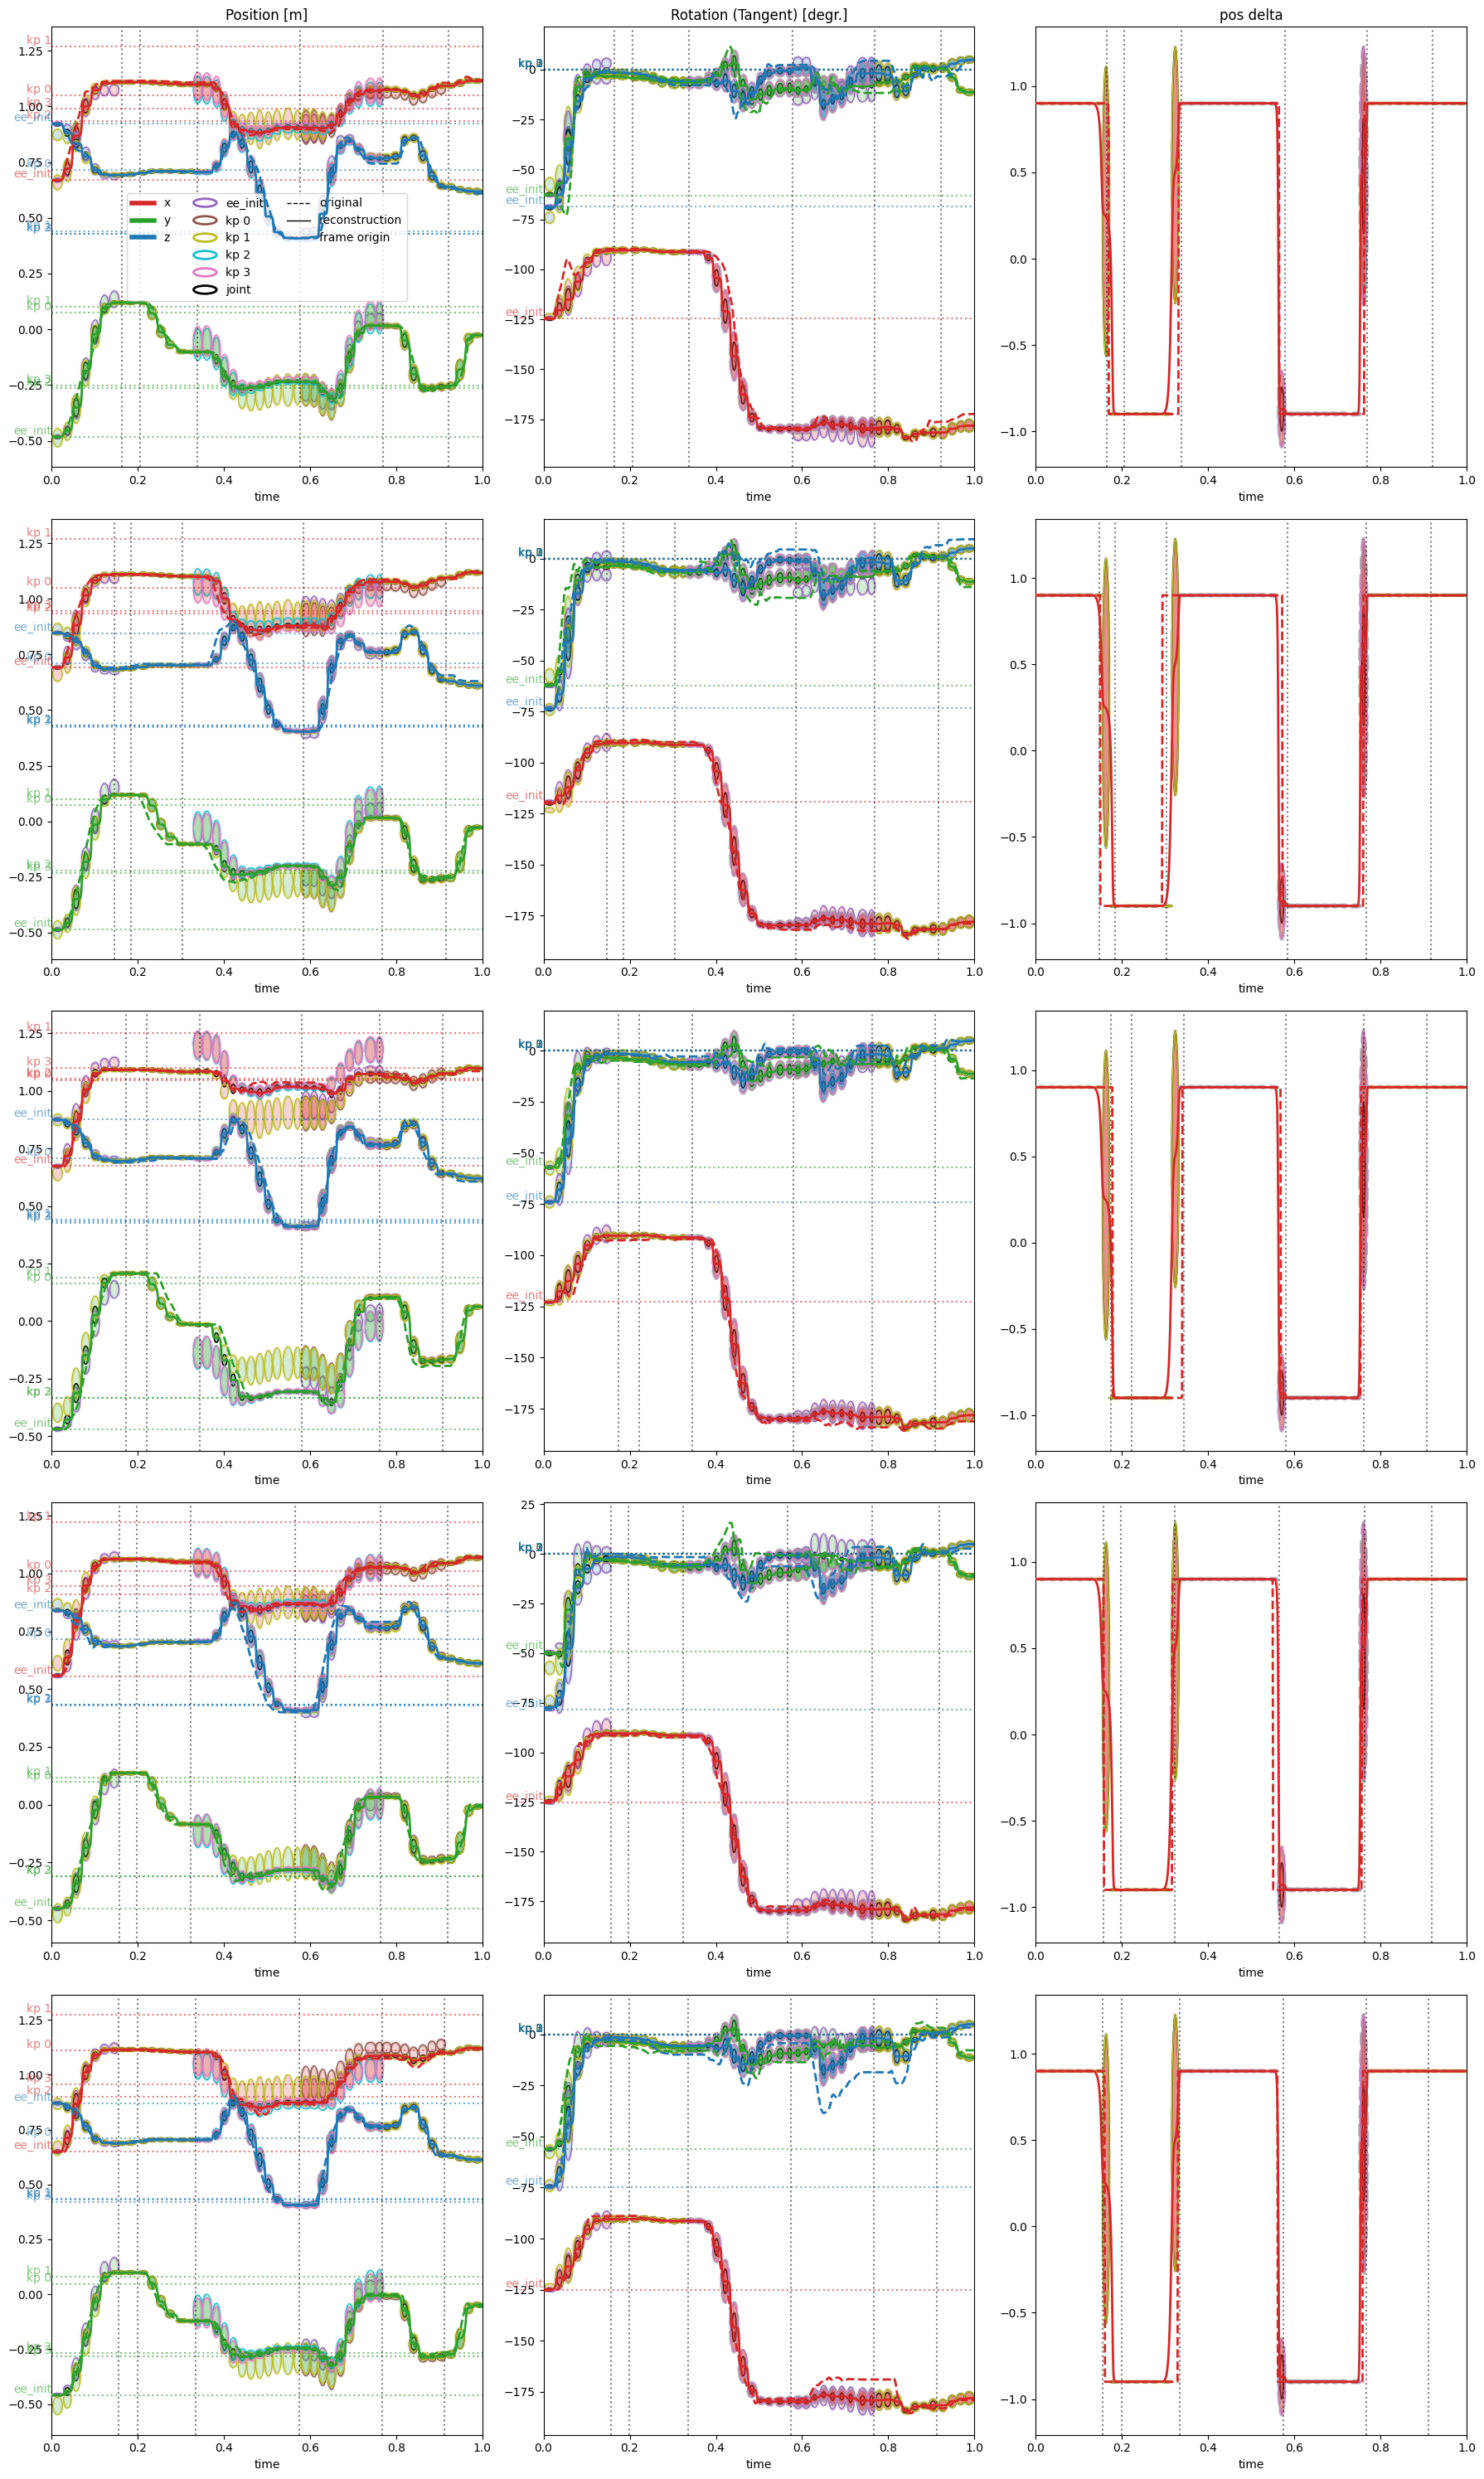

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


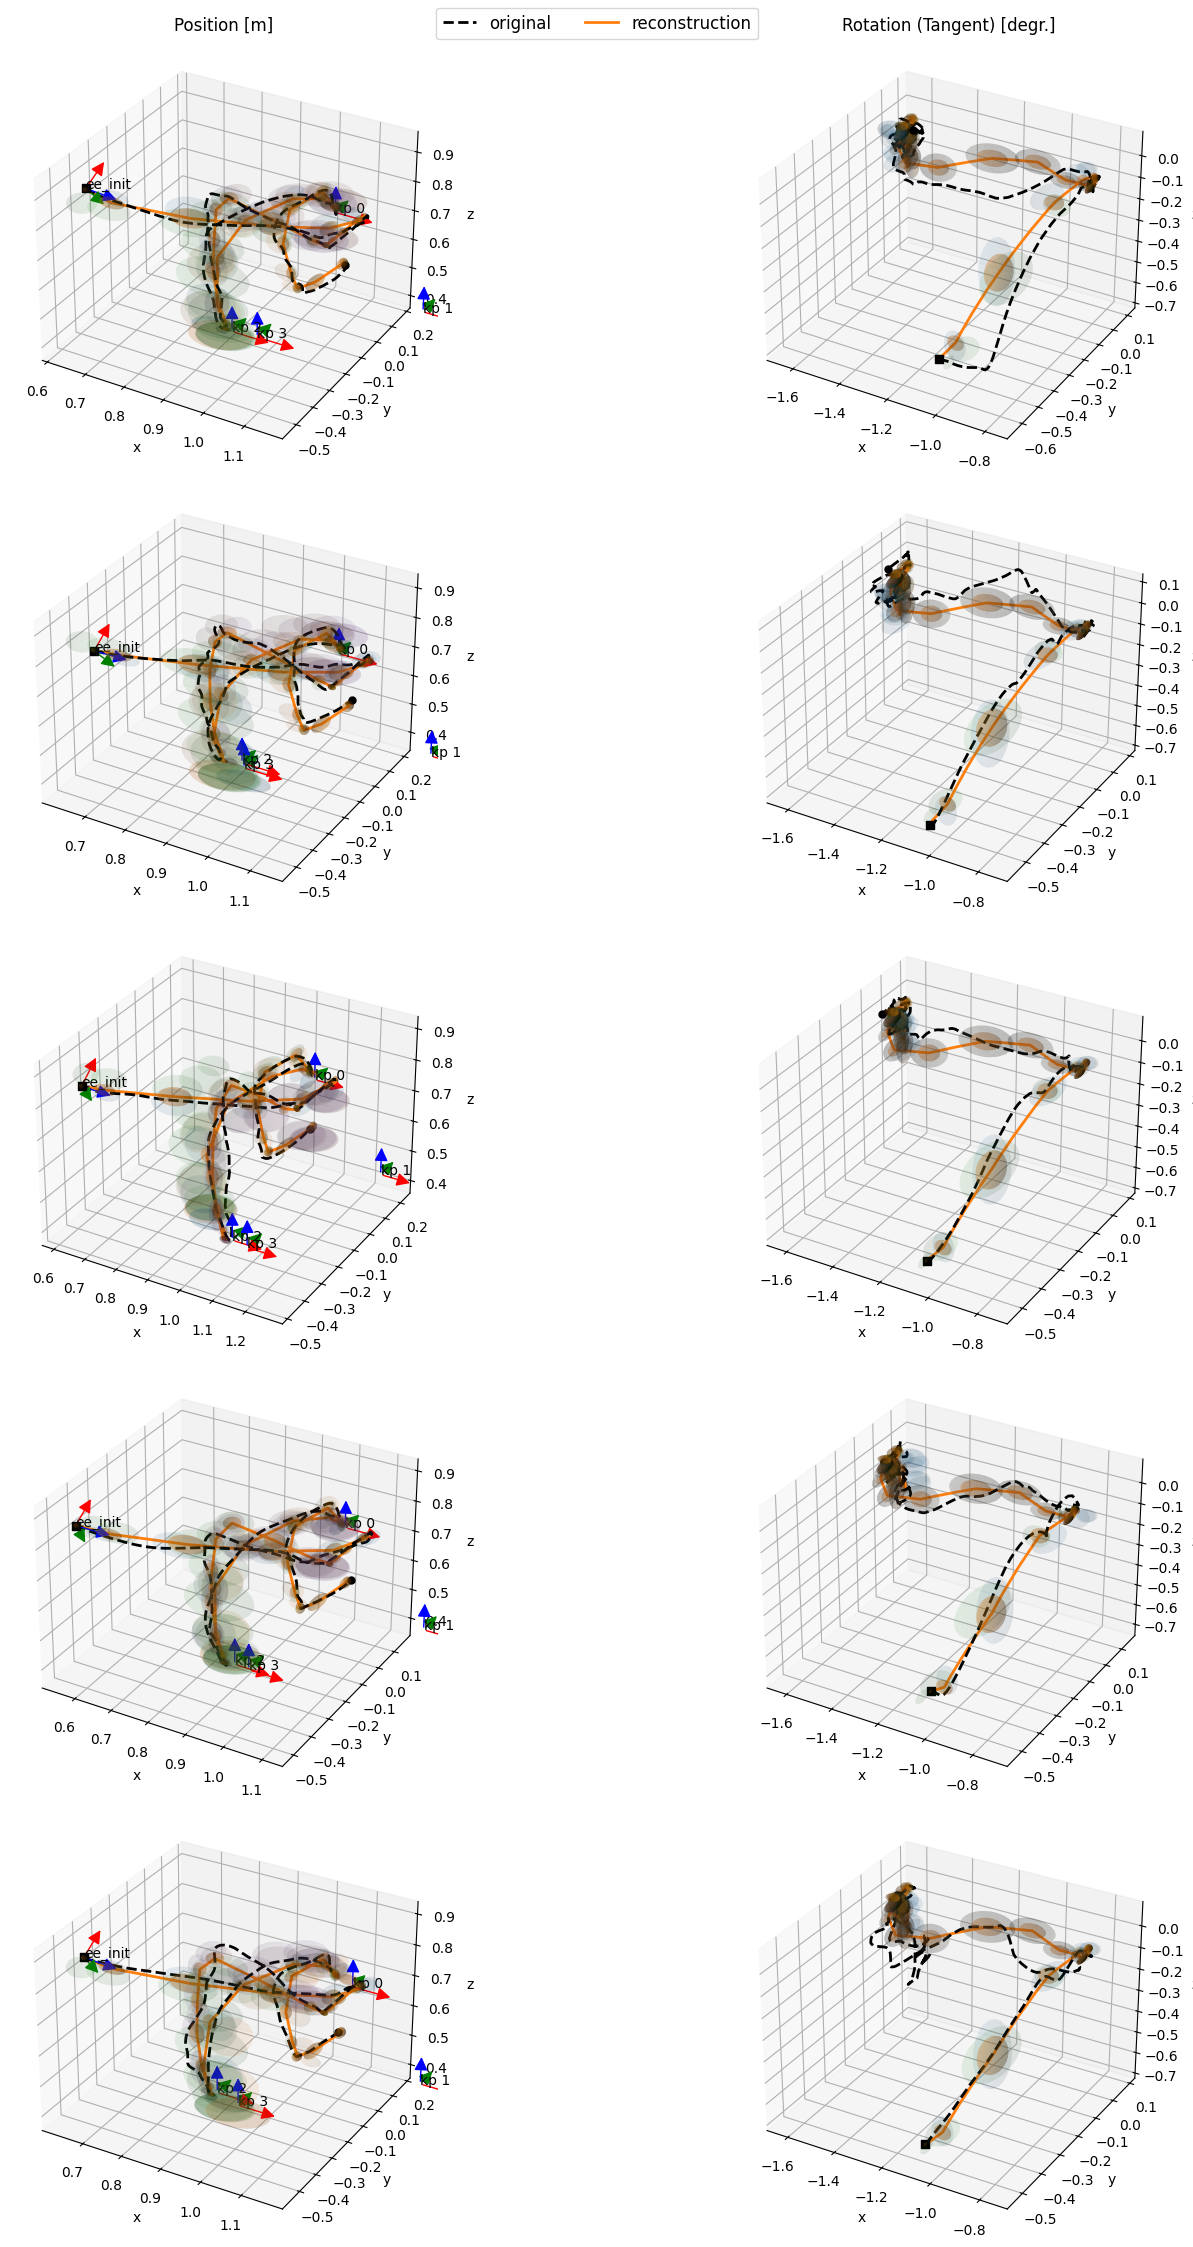

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=False, per_segment=False)